# Anomaly Detection with Salesforce Merlion (Unsupervised)

Applies **Salesforce Merlion** to generate anomaly scores on a market-derived time series using three unsupervised detectors:

- **Isolation Forest**
- **VAE** (Variational Autoencoder)
- **Ensemble** (Isolation Forest + VAE via `DetectorEnsemble`)

The goal is not labeled anomaly detection; instead, this analysis test whether anomaly scores carry information about *forward upside potential*.

## References
- Merlion: https://github.com/salesforce/Merlion  
- Merlion example: https://github.com/salesforce/Merlion/blob/main/examples/anomaly/1_AnomalyFeatures.ipynb  
- Isolation Forest (sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html  
- Merlion VAE implementation: https://github.com/salesforce/Merlion/blob/main/merlion/models/anomaly/vae.py  

---

## Data & target
- Data source: `yfinance`
- Asset: S&P 500 (`^GSPC`)
- Start date: `2000-01-01`
- Test split: last `400` observations

### Forward 20-day max return target
For each date $$t$$ with close $$C_t$$:

$$
target_t = 100 \times \frac{\max(C_{t+1}, \dots, C_{t+20}) - C_t}{C_t}
$$

Implementation detail: the max is computed over $$[t+1, t+20]$$ (starting tomorrow) to avoid look-ahead leakage.

---

## Method
### Models (Merlion)
- `IsolationForest(IsolationForestConfig())`
- `VAE(VAEConfig())`
- `DetectorEnsemble(...)` over both detectors, using `AggregateAlarms(alm_threshold=4)`

### Training & scoring
- Train on the target series as a univariate `TimeSeries` (no anomaly labels).
- Training anomaly scores are produced during `.train(...)`.
- Test anomaly scores are produced via `.get_anomaly_score(test_data)`.

### Evaluation (post-hoc)
This notebook treats the anomaly score as a candidate signal and reports:
- Correlation between $$target_t$$ and each anomaly score on **train**
- Correlation on **test**
- Train → test correlation drop as a rough generalization check

---

## Visual outputs
- Time series overlays (target vs anomaly scores) for train and test
- Correlation heatmaps (train/test)
- Score distribution comparisons (train/test)

---

## Key takeaways
- **VAE is the strongest single model in this run**: it shows the **highest correlation** with the forward $$20$$-day max return target on **both** the training and testing splits (relative to Isolation Forest and the ensemble).
- **Scale matters when comparing anomaly scores**: VAE produces **consistently larger-magnitude anomaly scores** than the other methods. This likely reflects **different score calibration/normalization** across detectors rather than “more anomalies” in an absolute sense.
- **Practical implication**: if you want a single unsupervised score that best tracks the forward-move proxy used here, **VAE is the best candidate** from these three. For downstream use, consider **standardizing scores** (e.g., z-score by a rolling window) before thresholding or combining with other signals.

---


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Data acquisition
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install salesforce-merlion --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 76.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompat

In [3]:
# Merlion
from merlion.utils import TimeSeries
from merlion.models.anomaly.isolation_forest import IsolationForest, IsolationForestConfig
from merlion.models.anomaly.vae import VAE, VAEConfig
from merlion.models.ensemble.anomaly import DetectorEnsemble, DetectorEnsembleConfig
from merlion.post_process.threshold import AggregateAlarms

sns.set_style('whitegrid')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7.7)
plt.rcParams['font.size'] = 11

In [4]:

# Set random seed for reproducibility
np.random.seed(2570)

CONFIG = {
    'ticker': '^GSPC',
    'start_date': '2000-01-01',
    'lookforward_window': 20,
    'test_size': 400,
}

In [5]:
def download_stock_data(ticker: str, start_date: str) -> pd.DataFrame:
    try:
        print(f"Downloading data for {ticker}...")
        stock = yf.Ticker(ticker)
        hist = stock.history(period="max")
        
        if hist.empty:
            raise ValueError(f"No data retrieved for {ticker}")
        
        hist.index = hist.index.date
        hist.index = pd.to_datetime(hist.index)
        df = hist[hist.index >= start_date].copy()
        print(f"Downloaded {len(df)} records from {df.index.min()} to {df.index.max()}")
        
        return df
    
    except Exception as e:
        print(f"Error downloading data: {str(e)}")
        raise


def calculate_forward_max_return(df: pd.DataFrame, 
                                 price_col: str = 'Close', 
                                 window: int = 20) -> pd.DataFrame:
    df = df.copy()
    
    # Fixed bug: Correct forward-looking calculation
    # Calculate rolling max of next 'window' days, starting from tomorrow
    future_max = []
    for i in range(len(df)):
        if i + window >= len(df):
            future_max.append(np.nan)
        else:
            future_max.append(df[price_col].iloc[i+1:i+window+1].max())
    
    df['future_max'] = future_max
    df['target'] = 100 * (df['future_max'] - df[price_col]) / df[price_col]
    
    df = df.dropna(subset=['target'])
    
    print(f"Calculated forward {window}-day max return")
    print(f"Target range: [{df['target'].min():.2f}%, {df['target'].max():.2f}%]")
    
    return df


def create_train_test_split(df: pd.DataFrame, 
                            test_size: int,
                            target_col: str = 'target') -> tuple:
    train_df = df[[target_col]].iloc[:-test_size].copy()
    test_df = df[[target_col]].iloc[-test_size:].copy()
    
    train_data = TimeSeries.from_pd(train_df)
    test_data = TimeSeries.from_pd(test_df)
    
    print(f"\nData Split:")
    print(f"Training: {len(train_df)} samples ({train_df.index.min()} to {train_df.index.max()})")
    print(f"Testing: {len(test_df)} samples ({test_df.index.min()} to {test_df.index.max()})")
    
    return train_data, test_data, train_df, test_df

In [6]:
def train_models(train_data: TimeSeries) -> dict:
    print("\nInitializing models...")
    
    iso_forest_config = IsolationForestConfig()
    iso_forest_model = IsolationForest(iso_forest_config)
    
    vae_config = VAEConfig()
    vae_model = VAE(vae_config)
    
    en_config = DetectorEnsembleConfig(threshold=AggregateAlarms(alm_threshold=4))
    en_model = DetectorEnsemble(config=en_config, models=[iso_forest_model, vae_model])
    
    print("\nTraining models...")
    
    iso_forest_train_score = iso_forest_model.train(train_data=train_data, anomaly_labels=None)
    print("Isolation Forest trained")
    
    vae_train_score = vae_model.train(train_data=train_data, anomaly_labels=None)
    print("VAE trained")
    
    en_train_score = en_model.train(train_data=train_data, anomaly_labels=None)
    print("Ensemble trained")
    
    return {
        'iso_forest': {'model': iso_forest_model, 'train_score': iso_forest_train_score},
        'vae': {'model': vae_model, 'train_score': vae_train_score},
        'ensemble': {'model': en_model, 'train_score': en_train_score}
    }

In [7]:
def evaluate_models(models: dict, 
                    train_df: pd.DataFrame, 
                    test_data: TimeSeries,
                    test_df: pd.DataFrame) -> tuple:
    print("\nEvaluating models...")
    
    # Combine training scores - FIXED: Use index alignment instead of .values
    df_train_scores = train_df.copy()
    
    # Get training scores as DataFrames with proper indices
    iso_forest_train_df = models['iso_forest']['train_score'].to_pd()
    iso_forest_train_df.columns = ['iso_forest_score']
    
    vae_train_df = models['vae']['train_score'].to_pd()
    vae_train_df.columns = ['vae_score']
    
    ensemble_train_df = models['ensemble']['train_score'].to_pd()
    ensemble_train_df.columns = ['ensemble_score']
    
    # Align by index to avoid length mismatch
    df_train_scores = pd.concat([
        df_train_scores,
        iso_forest_train_df,
        vae_train_df,
        ensemble_train_df
    ], axis=1)
    
    # Get test predictions
    df_test_scores = test_df.copy()
    
    # Isolation Forest
    if_test_scores = models['iso_forest']['model'].get_anomaly_score(test_data)
    if_test_df = if_test_scores.to_pd()
    if_test_df.columns = ['iso_forest_score']
    
    # VAE
    vae_test_scores = models['vae']['model'].get_anomaly_score(test_data)
    vae_test_df = vae_test_scores.to_pd()
    vae_test_df.columns = ['vae_score']
    
    # Ensemble
    en_test_scores = models['ensemble']['model'].get_anomaly_score(test_data)
    en_test_df = en_test_scores.to_pd()
    en_test_df.columns = ['ensemble_score']
    
    # Align by index
    df_test_scores = pd.concat([
        df_test_scores,
        if_test_df,
        vae_test_df,
        en_test_df
    ], axis=1)
    
    print(f"Model evaluation complete - Train shape: {df_train_scores.shape}, Test shape: {df_test_scores.shape}")
    
    return df_train_scores, df_test_scores

In [8]:


def print_correlation_analysis(df_train_scores: pd.DataFrame, 
                               df_test_scores: pd.DataFrame):
    print("\n" + "="*70)
    print("CORRELATION ANALYSIS")
    print("="*70)
    
    score_cols = ['iso_forest_score', 'vae_score', 'ensemble_score']
    
    print("\nTraining Data Correlations with Target:")
    for col in score_cols:
        corr = df_train_scores['target'].corr(df_train_scores[col])
        print(f"  {col:20s}: {corr:.4f}")
    
    print("\nTesting Data Correlations with Target:")
    for col in score_cols:
        corr = df_test_scores['target'].corr(df_test_scores[col])
        print(f"  {col:20s}: {corr:.4f}")
    
    print("\nPerformance Drop (Train -> Test):")
    for col in score_cols:
        train_corr = df_train_scores['target'].corr(df_train_scores[col])
        test_corr = df_test_scores['target'].corr(df_test_scores[col])
        drop = train_corr - test_corr
        drop_pct = (drop / train_corr) * 100 if train_corr != 0 else 0
        print(f"  {col:20s}: {drop:+.4f} ({drop_pct:+.1f}%)")

In [10]:
def create_visualization(df_train_scores: pd.DataFrame,
                         df_test_scores: pd.DataFrame):
    """
    Create comprehensive visualizations using Matplotlib and Seaborn.
    """
    print(f"\nCreating visualizations...")
    
    # Set Seaborn style for better aesthetics
    import seaborn as sns
    sns.set_style("whitegrid")
    sns.set_palette("colorblind")
    
    # Create figure with subplots
    fig, axes = plt.subplots(4, 2, figsize=(16, 16))
    fig.suptitle('Merlion Anomaly Detection Results', fontsize=16, fontweight='bold')
    
    # Adjust layout to prevent overlap
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    # 1. Training Data: Target vs Anomaly Scores
    ax1 = axes[0, 0]
    ax1.plot(df_train_scores.index, df_train_scores['target'], 
             color='black', linewidth=2, label='Target (20-day Max Return %)')
    ax1.set_ylabel('Target Return (%)', fontsize=10)
    ax1.set_title('Training Data: Target Returns', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Training Data: Anomaly Scores
    ax2 = axes[0, 1]
    ax2.plot(df_train_scores.index, df_train_scores['iso_forest_score'], 
             color='blue', linewidth=1, label='Isolation Forest')
    ax2.plot(df_train_scores.index, df_train_scores['vae_score'], 
             color='red', linewidth=1, label='VAE')
    ax2.plot(df_train_scores.index, df_train_scores['ensemble_score'], 
             color='green', linewidth=1, label='Ensemble')
    ax2.set_ylabel('Anomaly Score', fontsize=10)
    ax2.set_title('Training Data: Anomaly Scores', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Testing Data: Target vs Anomaly Scores
    ax3 = axes[1, 0]
    ax3.plot(df_test_scores.index, df_test_scores['target'], 
             color='black', linewidth=2, label='Target (20-day Max Return %)')
    ax3.set_ylabel('Target Return (%)', fontsize=10)
    ax3.set_title('Testing Data: Target Returns', fontsize=12, fontweight='bold')
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Testing Data: Anomaly Scores
    ax4 = axes[1, 1]
    ax4.plot(df_test_scores.index, df_test_scores['iso_forest_score'], 
             color='blue', linewidth=1, label='Isolation Forest')
    ax4.plot(df_test_scores.index, df_test_scores['vae_score'], 
             color='red', linewidth=1, label='VAE')
    ax4.plot(df_test_scores.index, df_test_scores['ensemble_score'], 
             color='green', linewidth=1, label='Ensemble')
    ax4.set_ylabel('Anomaly Score', fontsize=10)
    ax4.set_title('Testing Data: Anomaly Scores', fontsize=12, fontweight='bold')
    ax4.legend(loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    
    # 5. Correlation Heatmap: Training Data
    ax5 = axes[2, 0]
    train_corr = df_train_scores[['target', 'iso_forest_score', 'vae_score', 'ensemble_score']].corr()
    sns.heatmap(train_corr, annot=True, fmt='.3f', cmap='coolwarm', 
                center=0, ax=ax5, cbar_kws={'label': 'Correlation'})
    ax5.set_title('Training Data: Correlation Matrix', fontsize=12, fontweight='bold')
    
    # 6. Correlation Heatmap: Testing Data
    ax6 = axes[2, 1]
    test_corr = df_test_scores[['target', 'iso_forest_score', 'vae_score', 'ensemble_score']].corr()
    sns.heatmap(test_corr, annot=True, fmt='.3f', cmap='coolwarm', 
                center=0, ax=ax6, cbar_kws={'label': 'Correlation'})
    ax6.set_title('Testing Data: Correlation Matrix', fontsize=12, fontweight='bold')
    
    # 7. Distribution of Anomaly Scores: Training Data
    ax7 = axes[3, 0]
    sns.kdeplot(df_train_scores['iso_forest_score'], ax=ax7, label='Isolation Forest', color='blue')
    sns.kdeplot(df_train_scores['vae_score'], ax=ax7, label='VAE', color='red')
    sns.kdeplot(df_train_scores['ensemble_score'], ax=ax7, label='Ensemble', color='green')
    ax7.set_xlabel('Anomaly Score', fontsize=10)
    ax7.set_ylabel('Density', fontsize=10)
    ax7.set_title('Training Data: Score Distributions', fontsize=12, fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Distribution of Anomaly Scores: Testing Data
    ax8 = axes[3, 1]
    sns.kdeplot(df_test_scores['iso_forest_score'], ax=ax8, label='Isolation Forest', color='blue')
    sns.kdeplot(df_test_scores['vae_score'], ax=ax8, label='VAE', color='red')
    sns.kdeplot(df_test_scores['ensemble_score'], ax=ax8, label='Ensemble', color='green')
    ax8.set_xlabel('Anomaly Score', fontsize=10)
    ax8.set_ylabel('Density', fontsize=10)
    ax8.set_title('Testing Data: Score Distributions', fontsize=12, fontweight='bold')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    plt.tight_layout()    
    plt.show()


MERLION ANOMALY DETECTION PIPELINE
Downloaded 6546 records from 2000-01-03 00:00:00 to 2026-01-12 00:00:00
Calculated forward 20-day max return
Target range: [-5.27%, 28.48%]

Data Split:
Training: 6126 samples (2000-01-03 00:00:00 to 2024-05-08 00:00:00)
Testing: 400 samples (2024-05-09 00:00:00 to 2025-12-11 00:00:00)

Initializing models...

Training models...
Isolation Forest trained
 |========================================| 100.0% Complete, Loss 0.0010
VAE trained
 |========================================| 100.0% Complete, Loss 0.0010
Ensemble trained

Evaluating models...
Model evaluation complete - Train shape: (6126, 4), Test shape: (400, 4)

CORRELATION ANALYSIS

Training Data Correlations with Target:
  iso_forest_score    : 0.3515
  vae_score           : 0.5082
  ensemble_score      : 0.4330

Testing Data Correlations with Target:
  iso_forest_score    : 0.3874
  vae_score           : 0.5242
  ensemble_score      : 0.4530

Performance Drop (Train -> Test):
  iso_forest_s

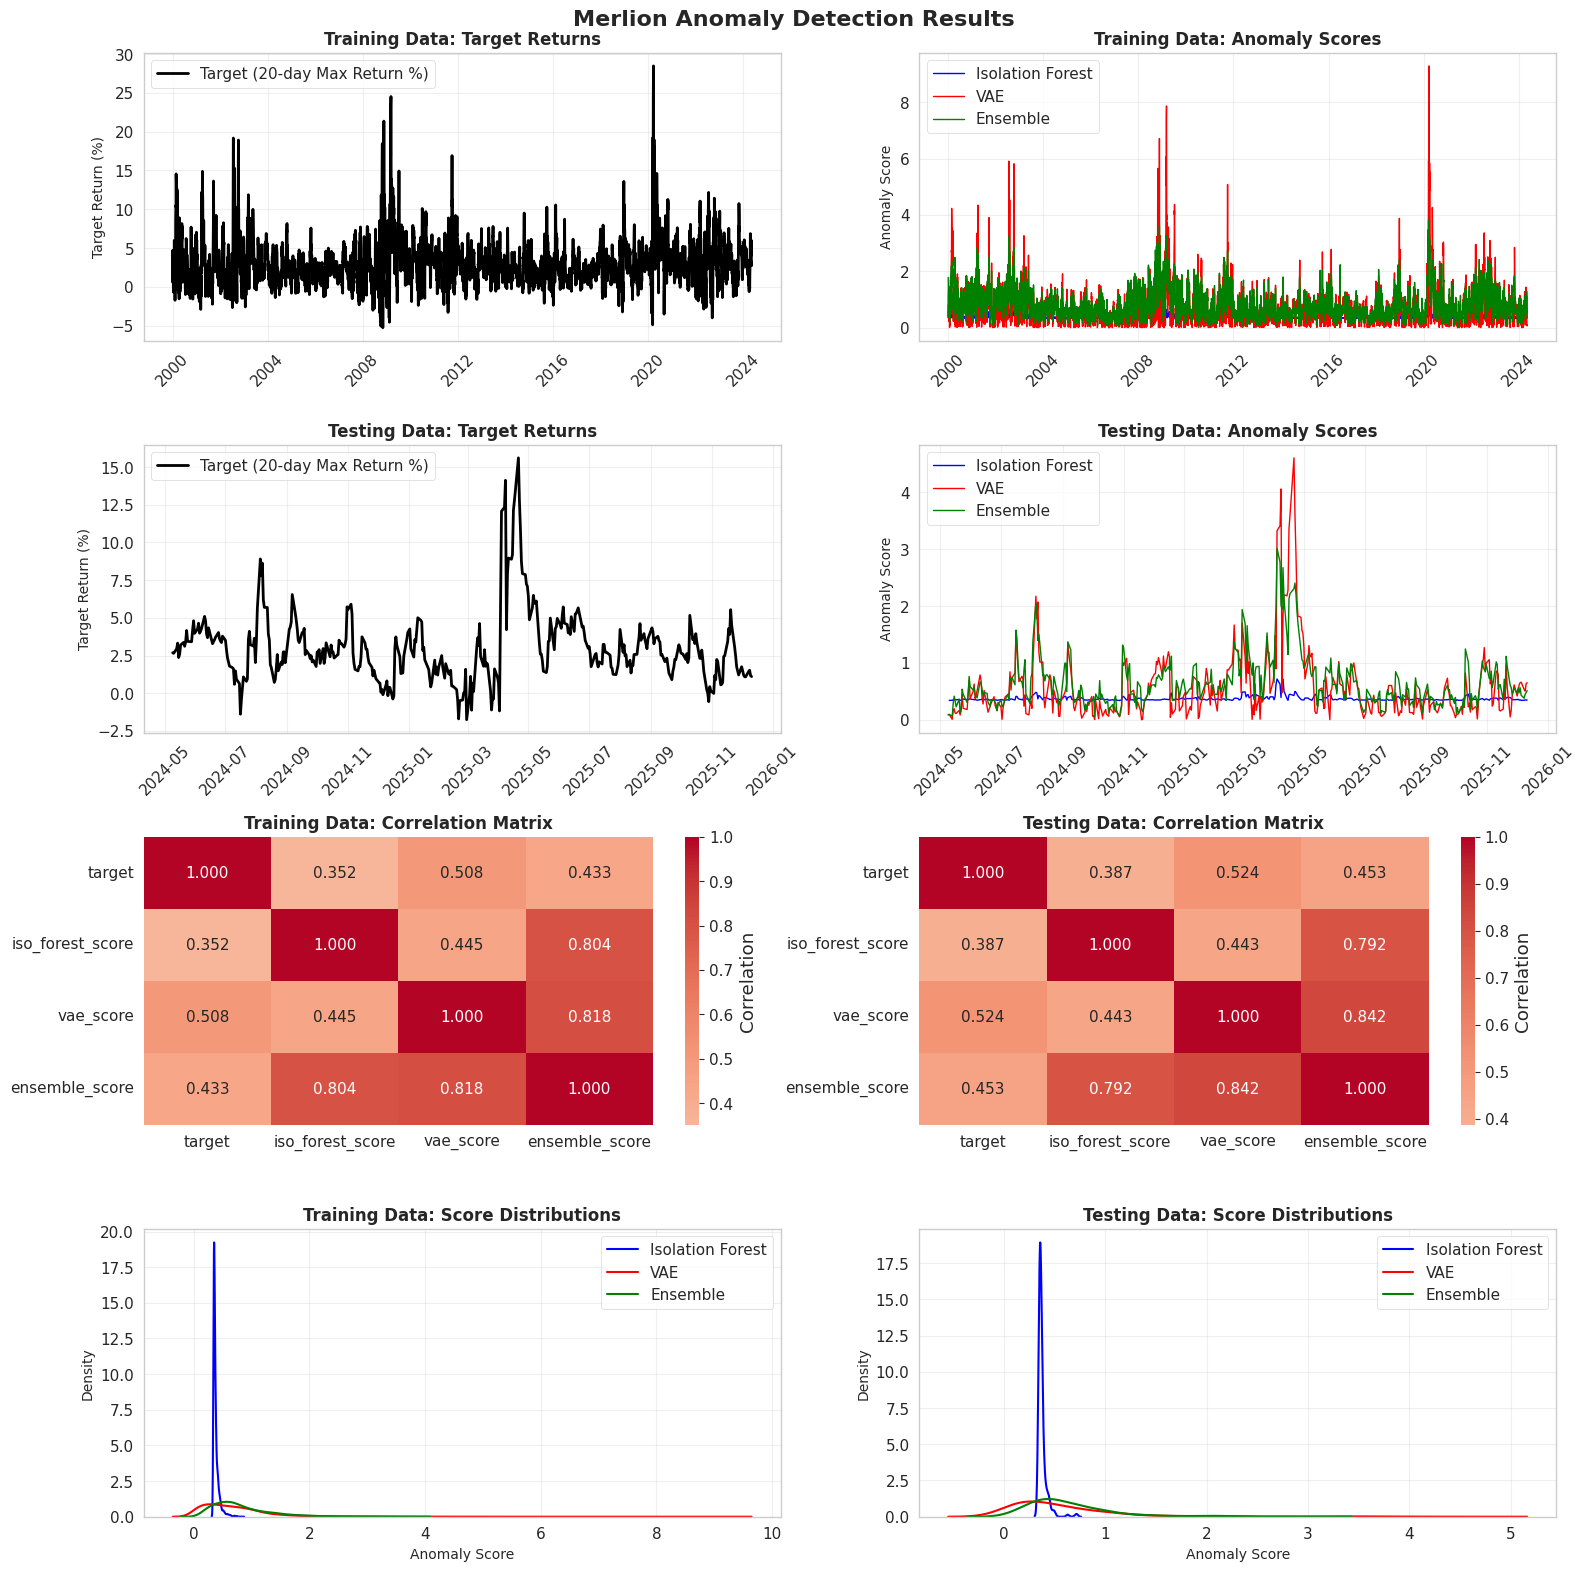

In [11]:
print("\n" + "="*70)
print("MERLION ANOMALY DETECTION PIPELINE")
print("="*70)

df = download_stock_data(CONFIG['ticker'], CONFIG['start_date'])

df = calculate_forward_max_return(
    df, 
    price_col='Close', 
    window=CONFIG['lookforward_window']
)

train_data, test_data, train_df, test_df = create_train_test_split(
    df, 
    CONFIG['test_size']
)

models = train_models(train_data)

df_train_scores, df_test_scores = evaluate_models(
    models, 
    train_df, 
    test_data, 
    test_df
)

print_correlation_analysis(df_train_scores, df_test_scores)

create_visualization(
    df_train_scores, 
    df_test_scores
)
